In [186]:
%matplotlib inline
import pandas as pd
import gzip
import numpy as np
from scipy.optimize import minimize
from datetime import timedelta
import tensorflow as tf
from datetime import timedelta
from scipy.sparse import csr_matrix
from dateutil.parser import parse
import json

In [2]:
#inputfile="/home/sathappan/workspace/time2event/hawkes/data/all_trades.csv"
#inputfile="/Users/nikhil/phd/urban_computing/wmata/repos/PointProcess/data/all_trades.csv"
def read_data(inputfile,_e=1.667e-6):
    """
        Read inputfile , process difference between first event and each subsequent event.
        Assumption is that events are in sorted order by datetime.
    """
    
    df = pd.read_csv(inputfile)
    df.t = pd.to_datetime(df.t)
    pp = (df.t - df.t[0]).apply(lambda x: x/np.timedelta64(1, 'm')).value_counts()
    events = []
    e = _e
    for t, cnt in pp.iteritems():
        base_time = t
        for i in range(cnt):
            #here we just add i*e_i (a very small perturbation) to avoid collisions.
            events.append(base_time + e*i)  

    events = np.array(sorted(events))
    empirical = df.t
    empirical_counts = empirical.value_counts().resample(rule='1min').sum()
    events = events[None, :]   #None operation adds an extra dimention of size 1 to events.
    return events,empirical_counts


In [70]:
inputfile="/Users/nikhil/phd/urban_computing/wmata/repos/PointProcess/data/all_trades.csv"
events_all,empirical_counts_all=read_data(inputfile)

array([[  0.00000000e+00,   1.66700000e-06,   2.50000000e-01, ...,
          4.05966667e+02,   4.06000000e+02,   4.06000002e+02]])

In [40]:
def calc_Ai(arrivals, mask, beta):
    tdiff = np.diff(arrivals) * mask[:, 1:]
    tdiff = np.exp(tdiff * -beta)
    A_i = np.zeros_like(arrivals, dtype=np.float128)
    for i in range(tdiff.shape[1]):
        #print(i,)
        A_i[:, i + 1] = tdiff[:, i] * (1 + A_i[:, i])
    return A_i, tdiff

In [41]:
#A_i, tempdiff = calc_Ai(events, mask, 1.0)

In [42]:
def calc_temporal_differences(arrivals, mask):
    #U X T X T tensor.
    temporal_diff = np.zeros((arrivals.shape[0], arrivals.shape[1], arrivals.shape[1]))
    #mask_tempdiff = np.zeros_like(temporal_diff)
    for t_i in range(arrivals.shape[1]):
        temporal_diff[:, :t_i, t_i] = arrivals[:, t_i] - arrivals[:, :t_i]
        #mask_tempdiff[:, :t_i, t_i] = 1.0
    mask_tempdiff = (temporal_diff != 0) 
    
    return mask_tempdiff, temporal_diff
    ### Create a UsersxTimexTime matrix

In [43]:
mask = np.ones_like(events)
mask_tdiff, temporal_diff = calc_temporal_differences(events, mask)

In [44]:
mask_tdiff[:,:2,:5],temporal_diff[:,:2,:5]

(array([[[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True]]], dtype=bool),
 array([[[  0.00000000e+00,   1.66700000e-06,   2.50000000e-01,
            2.11666667e+00,   2.16666667e+00],
         [  0.00000000e+00,   0.00000000e+00,   2.49998333e-01,
            2.11666500e+00,   2.16666500e+00]]]))

In [45]:
def loglikelihood():
    #tdiff = diff(arrivals) * mask[:, 1:]
    #A_i = tf.zeros_like(arrivals)
    #for i in range(tdiff.shape[0]):
    #    A_i[:, i + 1] = tdiff[:, i] * (1 + A[:, i ])
    #part1 = tf.log(mu + alpha * ais_tvar)
    #part1 = tf.reduce_sum(tf.log(mu + alpha * ais_tvar), axis=1)[:, None]
    hist_effects = tf.reduce_sum((tf.exp(-beta[:, :, None] * temp_diff_tvar))\
                                 *mask_tdiff_tvar, axis=2)
    part1 = tf.reduce_sum(tf.log(mu + alpha * hist_effects), axis=1)
    #part1 = tf.reduce_sum()
    T_max = tf.reduce_max(arrivals_tvar*mask_tvar, axis=1)[:, None]
    part2 = mu * T_max
    tmp = tf.exp(-beta * ((T_max - arrivals_tvar)*mask_tvar))
    p3_tmp = tf.reduce_sum(tmp - tf.constant(1.0, dtype=tf.float64), axis=1)
    part3 = (alpha / beta)* p3_tmp[:, None]
    
    #return part1, part2, part3, part1 - part2 + part3
    return tf.reduce_sum(part1 - part2 + part3)

In [46]:
mask.shape,mask_tdiff.shape

((1, 5000), (1, 5000, 5000))

In [47]:
num_users = 1
alpha = tf.Variable(tf.random_uniform([num_users, 1], dtype=tf.float64), name='alpha')
beta = tf.Variable(tf.random_uniform([num_users, 1], dtype=tf.float64), name='beta')
mu = tf.Variable(tf.random_uniform([num_users, 1], dtype=tf.float64), name='mu')

In [48]:
#T_max = 5000
T_max = mask_tdiff.shape[1] 
arrivals_tvar = tf.placeholder(tf.float64, [None, T_max])
mask_tvar = tf.placeholder(tf.float64, [None, T_max])
temp_diff_tvar = tf.placeholder(tf.float64,[None, T_max, T_max])
mask_tdiff_tvar = tf.placeholder(tf.float64, [None, T_max, T_max])

In [49]:
def cost_func():
    conv=0.4
    nloglik = -loglikelihood()
    #regularizer = tf.reduce_sum(alpha)  + tf.reduce_sum(mu) + tf.reduce_sum(alpha/beta) 
    regularizer = tf.reduce_sum(alpha)+tf.reduce_sum(mu)+tf.reduce_sum(beta) +\
    tf.reduce_sum(tf.square(alpha))+tf.reduce_sum(tf.square(beta))+tf.reduce_sum(tf.square(mu))#-tf.reduce_sum(tf.abs(alpha))-tf.reduce_sum(tf.abs(beta))
    return (1-conv)*regularizer + (conv)*nloglik

In [50]:
#p3 = loglikelihood()
p3 = cost_func()
#grad = tf.gradients(p3, [alpha, beta, mu])

optim = tf.train.GradientDescentOptimizer(0.000001).minimize(p3)
#clip_alpha = alpha.assign(tf.maximum(0.05, alpha))
#clip_beta = beta.assign(tf.maximum(0.05, beta))

#commented_nikhil
#gr_alpha, gr_beta, gr_mu  = optim.compute_gradients(p3)

In [51]:
# gr_alpha = (tf.clip_by_value(gr_alpha[0], 0.01, np.infty), gr_alpha[1])
# gr_beta = (tf.clip_by_value(gr_beta[0], 0.01, np.infty), gr_beta[1])
# gr_mu = (tf.clip_by_value(gr_mu[0], 0.01, np.infty), gr_mu[1])

#commented_nikhil_start
#minmzr = optim.apply_gradients([gr_alpha,gr_beta, gr_mu])
#commented_nikhil_end

#p1, p2, p3 = loglikelihood()
#capped_gvs = [(tf.clip_by_value(grad, 0, 1), var) for grad, var in gvs]
#train_op = optim.apply_gradients(capped_gvs)

In [52]:
#np.random.seed(12345)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    #print("Initial Value of alpha, beta and gamma", gr_alpha[1].eval(),gr_beta[1].eval(),gr_mu[1].eval())
    _cost=list()
    _alphas=list()
    _betas=list()
    _mus=list()
    print("Initial Vals","alpha",alpha.eval(),"beta",beta.eval())
    #tf_a = (sess.run([gr_alpha, minmzr], feed_dict={arrivals_tvar: np.nan_to_num(arrivals_numpy), mask_tvar:mask, ais_tvar:A_i, tdiff_tvar: tempdiff}))
    for i in range(50):
#         _, c, al, bt,m = (sess.run([minmzr, p3, alpha, beta, mu], \
#                                    feed_dict={arrivals_tvar: np.nan_to_num(events),\
#                                               mask_tvar:mask, temp_diff_tvar: temporal_diff,\
#                                               mask_tdiff_tvar:mask_tdiff}))
        op,c,al,bt,m=(sess.run([optim,p3,alpha,beta,mu],feed_dict={arrivals_tvar: np.nan_to_num(events),\
                                   mask_tvar:mask, temp_diff_tvar: temporal_diff,\
                                   mask_tdiff_tvar:mask_tdiff}))
        if not (i%50):
            print("Iter ",i,"cost",c,"al",al,"bt",bt,"m",m)
        _cost.append(c)
        _betas.append(bt)
        _alphas.append(al)
#         if alpha.eval()<0 or alpha.eval()>100:
#             print("Iter ",i,"Before Clipping Alpha",alpha.eval())
#             val=tf.stack(np.random.random(alpha.get_shape()))
#             alpha=tf.assign(alpha,val)
#             print("After Clipping Alpha",alpha.eval())

#         if beta.eval()<0 or beta.eval()>100:
#             print("Iter ",i,"Before Clipping Beta",beta.eval())
            
#             val=tf.stack(np.random.random(beta.get_shape()))
#             beta=tf.assign(beta,val)
#             print("After Clipping Beta",beta.eval())
        if not (i % 50):
            #print(c)
            #print(al, bt, m)
            pass
    #tf_a, tf_b, tf_c, tf_d = (sess.run(p3, feed_dict={arrivals_tvar: np.nan_to_num(arrivals_numpy), mask_tvar:mask, ais_tvar:A_i, tdiff_tvar: tempdiff}))

Initial Vals alpha [[ 0.52438132]] beta [[ 0.80436675]]
Iter  0 cost -3747.87112142 al [[ 0.52544214]] bt [[ 0.80400995]] m [[ 0.65586428]]


KeyboardInterrupt: 

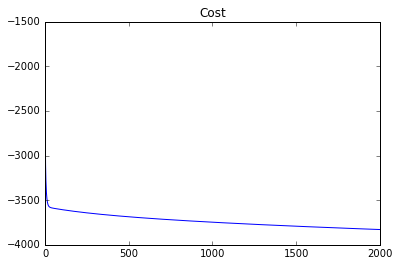

In [17]:
import matplotlib.pyplot as plt
plt.plot(_cost)
plt.title("Cost")

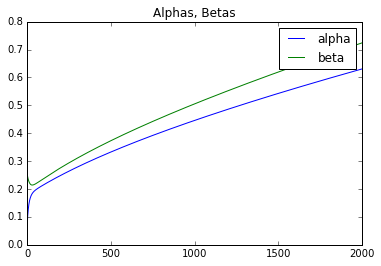

In [18]:
plt.plot([val[0][0] for val in _alphas])
plt.plot([val[0][0] for val in _betas])
plt.title("Alphas, Betas")
plt.legend(["alpha","beta"])

In [21]:
#cd ..

/Users/nikhil/phd/urban_computing/wmata/repos


In [66]:
mu=0.99304723
alpha=0.6218229
beta=0.71359743

def visualize_fit(alpha,beta,mu):
    from PointProcess.hawkes import UniVariateHawkes
    u = UniVariateHawkes()
    compensators = u.calc_compensator(mu, alpha, beta, np.arange(events.shape[1]), events)
    timepoints = np.linspace(int(events.min()), int(events.max()), events.shape[1])
    cif = u.calc_conditionIntensity(mu, alpha, beta, timepoints, events)
    plt.figure(figsize=(20,5))
    plt.plot(timepoints, cif)
    plt.plot(range(407), empirical_counts.values, alpha=.4)


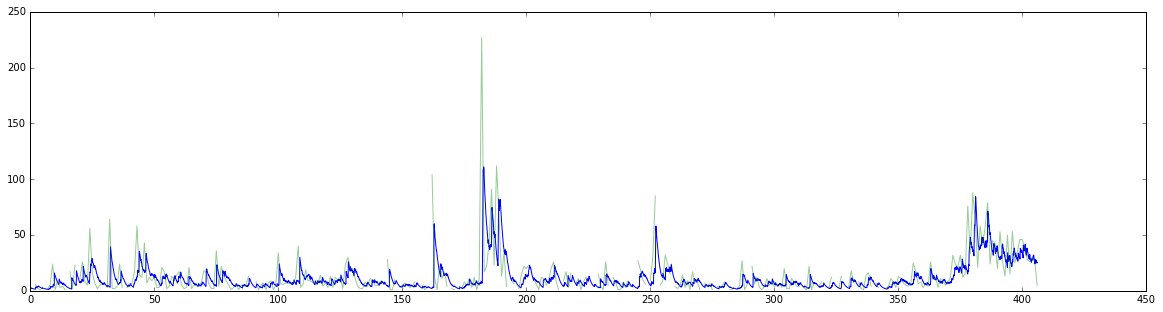

In [67]:
visualize_fit(alpha,beta,mu)

In [68]:
events.shape

(1, 5000)

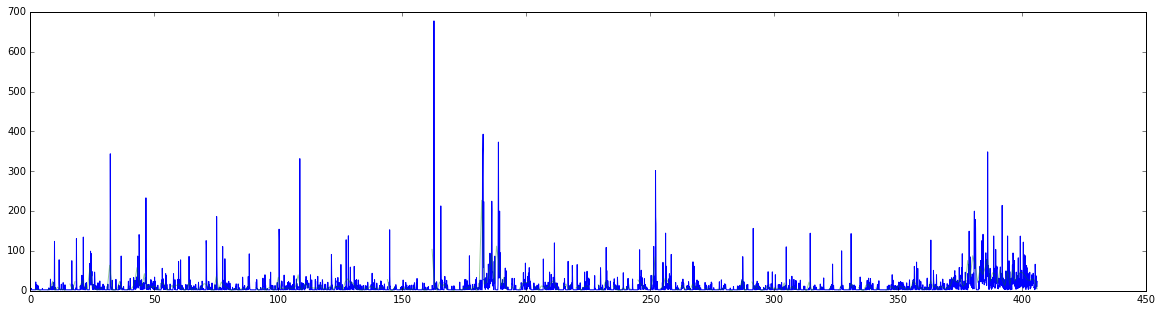

In [69]:
mu=2.52
alpha=13.14
beta=18.15
visualize_fit(alpha,beta,mu)

# compensators = u.calc_compensator(mu, alpha, beta, np.arange(500), events)
# timepoints = np.linspace(int(events.min()), int(events.max()), 100)
# cif = u.calc_conditionIntensity(mu, alpha, beta, timepoints, events)
# plt.figure(figsize=(20,5))
# plt.plot(timepoints, cif)

# plt.plot(range(407), empirical_counts.values, alpha=.4)

In [4]:
import numpy as np
from datetime import datetime as dt

#Testing with WMATA Data
inputfile1="/Users/nikhil/phd/urban_computing/datasets/wmata/wmata_2015_2016/user_timeseries_sorted_100.gz"
inputfile2="/Users/nikhil/phd/urban_computing/wmata/repos/PointProcess/data/all_trades.csv"
#wmata_events,wmata_empirical_counts=read_data(inputfile1)
#bitcoin_events,bitcoin_empirical_counts=read_data(inputfile2)

#We expect event_list to be a series object of value_counts.
def _perturb(event_list,_e=1.667e-4):
    events=list()
    for t, cnt in event_list.iteritems():
        base_time = t
        for i in range(cnt):
            #here we just add i*e_i (a very small perturbation) to avoid collisions.
            events.append(base_time + (_e*i))  
    return events

def generate_train_test(_user_events):
    pass

def read_data_wmata(inputfile,scaletimeunit='D',precision=4,_e=1.667e-6,num_users=10,test_percentage=0.2):
    with gzip.open(inputfile) as f:
        cnt = 0
        user_events_train = list()
        user_events_test=list()
        user_ids= list()
        empirical_counts=list()
        for idx,line in enumerate(f):
            if idx >= num_users:
                break

            _user_events=list()
            _tmp=json.loads(line.decode('utf-8'))
            _user_events=pd.Series(sorted([parse(_dt) for _dt in _tmp['arrivalTimes']]))
                        
            user_ids.append(_tmp['_id'])
            _user_events=((_user_events - _user_events[0]).apply(lambda x:
                        round(x/np.timedelta64(1, scaletimeunit),precision))
                          .value_counts().sort_index())
            all_user_events=_perturb(_user_events)
            train_end_idx=len(all_user_events) - int(len(all_user_events)*test_percentage)
            #print(train_end_idx,len(all_user_events))
            test_user_events=all_user_events[train_end_idx+1:]
            train_user_events=all_user_events[:train_end_idx]
            user_events_train.append(train_user_events)
            user_events_test.append(test_user_events)
            empirical=pd.Series(sorted([parse(_dt) for _dt in _tmp['arrivalTimes']]))
            emp_cnt_val=empirical.value_counts().resample(rule=scaletimeunit).sum()
            empirical_counts.append(emp_cnt_val)
            
    user_events_train=pd.DataFrame(user_events_train)
    mask_train = ~(user_events_train.isnull()).as_matrix()
    user_events_test=pd.DataFrame(user_events_test)
    mask_test = ~(user_events_test.isnull()).as_matrix()
    
    return np.nan_to_num(user_events_train.as_matrix()),np.nan_to_num(user_events_test.as_matrix()),mask_train,mask_test,empirical_counts,user_ids


In [321]:
events_train,events_test,mask_train,mask_test,empirical_counts,user_ids=read_data_wmata(inputfile1,test_percentage=0.2)


In [290]:
empirical_counts[0].shape

(714,)

In [294]:
events_train[0]

numpy.ndarray

<h1> Model Validation <h2>

In [187]:
import pickle
import matplotlib.pyplot as plt
with open("modelparams.pkl","rb") as f:
    data=pickle.load(f)

In [188]:
data.keys()

dict_keys(['betas', 'mask_test', 'args', 'empirical_counts', 'cost', 'events_test', 'events_train', 'user_ids', 'mask_train', 'alphas', 'mus'])

In [189]:
user_params=dict()
for idx in range(data['alphas'].shape[0]):
    _uid=data['user_ids'][idx]
    _alpha=data['alphas'][idx][-1]
    _beta=data['betas'][idx][-1]
    _mu=data['mus'][idx][-1]
    _events_test=data['events_test'][idx]
    _events_train=data['events_train'][idx]
    _mask_test=data['mask_test'][idx]
    _mask_train=data['mask_train'][idx]
    user_params[_uid]={'alpha':_alpha,'beta':_beta,'mu':_mu,'events_test':_events_test,
                       'mask_test':_mask_test,'mask_train':_mask_train,
                       'events_train':_events_train,
                       'empirical_counts':data['empirical_counts'][idx]}   

In [211]:
def create_df(events,startdate,scaletimeunit):
    events_dt_index=startdate + pd.to_timedelta(events,unit=scaletimeunit)
    return pd.DataFrame(np.ones_like(events),index=events_dt_index)

def calc_cif(alpha,beta,mu,events,_df,empirical_counts,hawkesciftimeunit='h',emp_time_unit='D'):
    from hawkes.hawkes import UniVariateHawkes
    u = UniVariateHawkes()
    _max=empirical_counts.index.max()
    _min=empirical_counts.index.min()
    _emp=empirical_counts[(empirical_counts.index>=_df.index.min()) 
                          &(empirical_counts.index<=_df.index.max())].fillna(0)
    
    cif=list()
    cnts=list()
    rng=pd.date_range(start=_df.index.min(),end=_df.index.max(),freq=hawkesciftimeunit)
    tdeltas=(rng - _min)/np.timedelta64(1,hawkesciftimeunit)
    ctr=0
    for _dt,tdelta in zip(rng,tdeltas):
        ctr+=1
        cif_t = u.calc_conditionIntensity(mu, alpha, beta, [tdelta], events[events<tdelta])
        _tmp_cnts=_emp[_emp.index==pd.Timestamp(_dt.date())].fillna(0).values
        if isinstance(_tmp_cnts,list):
            print(_tmp_cnts,_dt)
        if len(_tmp_cnts)>0:
            cnts.append(_tmp_cnts[0])
        else:
            #print(_dt,tdelta)
            cnts.append(0)
        cif.append(cif_t)
    
    #plt.ylim(0,10)
    return rng,cnts,cif,_emp

def test_hawkes(alpha,beta,mu,train_events,test_events,empirical_counts,scaletimeunit='D',user_id=None):
    from hawkes.hawkes import UniVariateHawkes
    u = UniVariateHawkes()
    _min_timept=int(test_events.min()) 
    _max_timept=int(test_events.max())
    cif=list()
    tstps=list()
    cnts=list()
    _min_day_emp_cnts=empirical_counts.index.min()
    dtrng=pd.date_range(start=_min_day_emp_cnts,periods=_max_timept+1,freq=scaletimeunit)
    _events_index=list()
    
    train_df=create_df(train_events,_min_day_emp_cnts,scaletimeunit=scaletimeunit)
    test_df=create_df(test_events,_min_day_emp_cnts,scaletimeunit=scaletimeunit)
    
    rng_train,cnts_train,cif_train,_emp_train=calc_cif(alpha,beta,mu,train_events
                          ,train_df,empirical_counts,hawkesciftimeunit='D')

    rng_test,cnts_test,cif_test,_emp_test=calc_cif(alpha,beta,mu,test_events
                          ,test_df,empirical_counts,hawkesciftimeunit='D')
    
    _min_day_emp_cnts=_tmp['empirical_counts'].index.min()
    cnts_train.extend(cnts_test)
    fig,ax=plt.subplots(1,1,figsize=(20,6))
    ax.plot(cnts_train,color='r',alpha=0.6)
    ax.plot(cif_train,color='b')
    ax.set_ylim(0,10)
    cifplt=([0]*len(cif_train))
    cifplt.extend(cif_test)
    ax.plot(cifplt,color='g')
    ax.set_title("al = "+str(alpha)+" bt = "+str(beta)+" mu = "+str(mu),fontsize=25)
    fig.savefig("figures/"+user_id+".png",dpi=400)
    cond_intensity=list()
    cnts=list()
    cnts=cnts_train
    cond_intensity.extend(cif_train)
    cond_intensity.extend(cif_test)
    return cnts,cond_intensity
def plot_users(user_data,step='D'):
    dtw=dict()
    for _id in user_data.keys():
        _tmp=user_params[_id]
        _al=_tmp['alpha']
        _bt=_tmp['beta']
        _mu=_tmp['mu']
        _ev_train=_tmp['events_train'][_tmp['mask_train']]
        _ev_tst=_tmp['events_test'][_tmp['mask_test']]
        _emp_cnt=_tmp['empirical_counts'].fillna(0)
        empcnts,cond_int=test_hawkes(_al,_bt,_mu,_ev_train,_ev_tst,_emp_cnt,scaletimeunit=step,user_id=_id)
        dtw[_id]={'counts':empcnts,'intensity':cond_int}
        
    return dtw

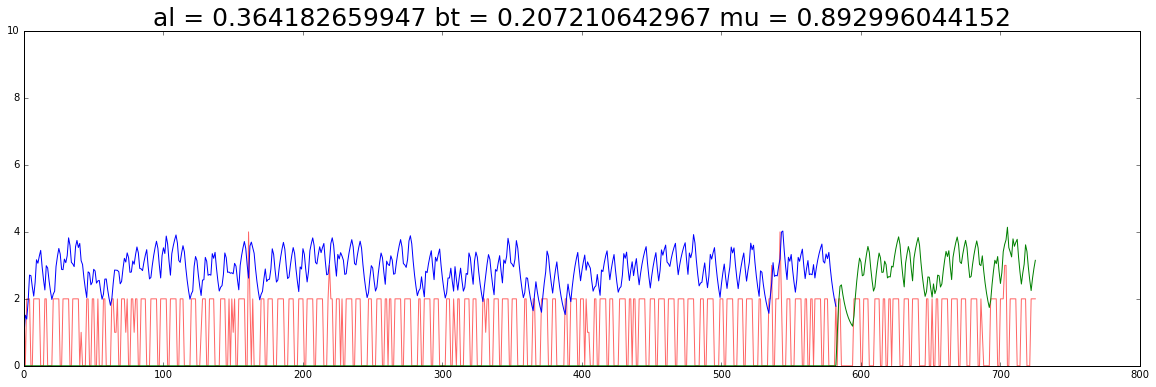

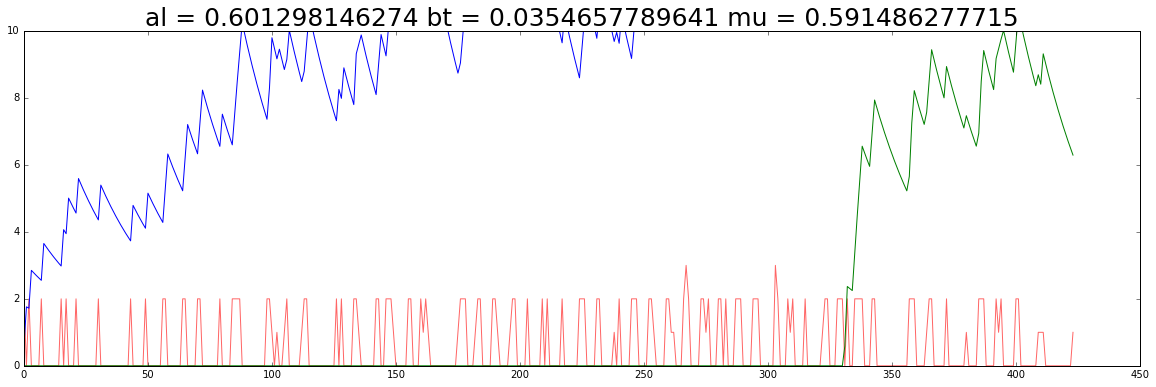

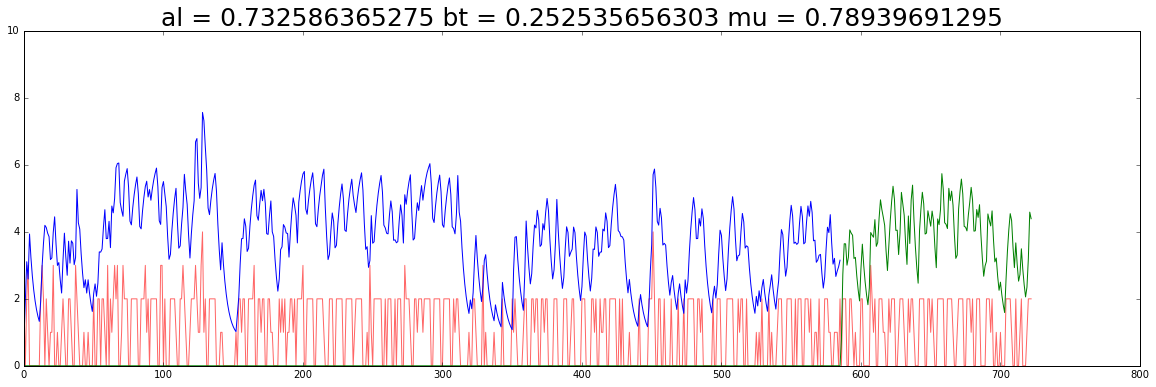

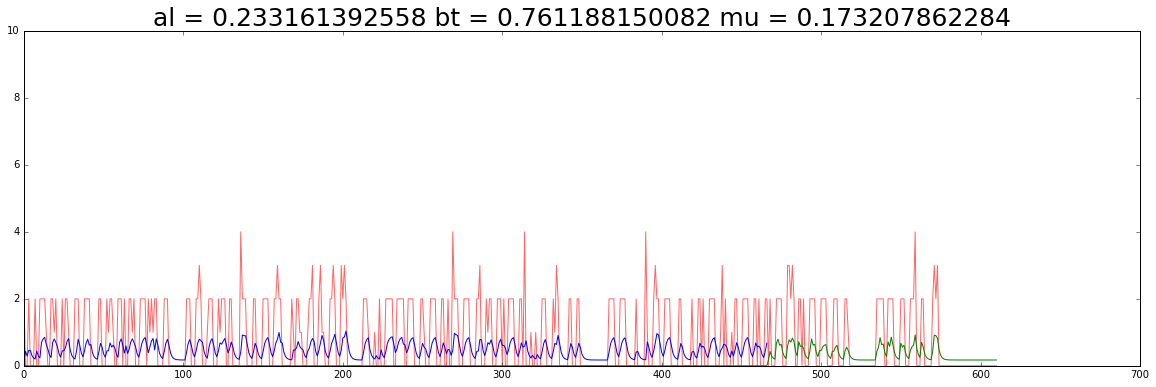

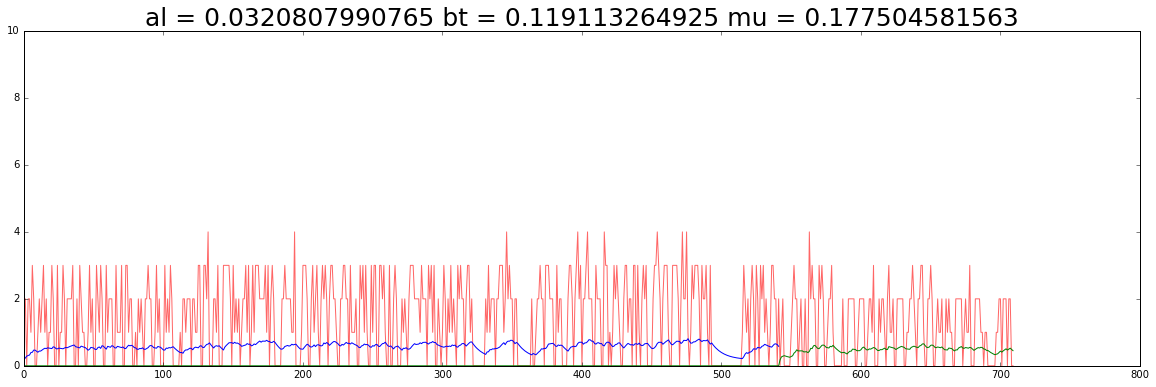

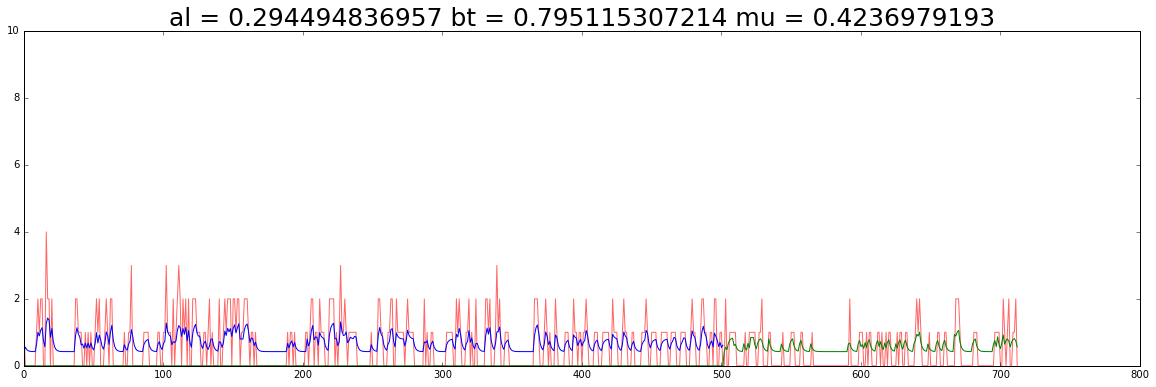

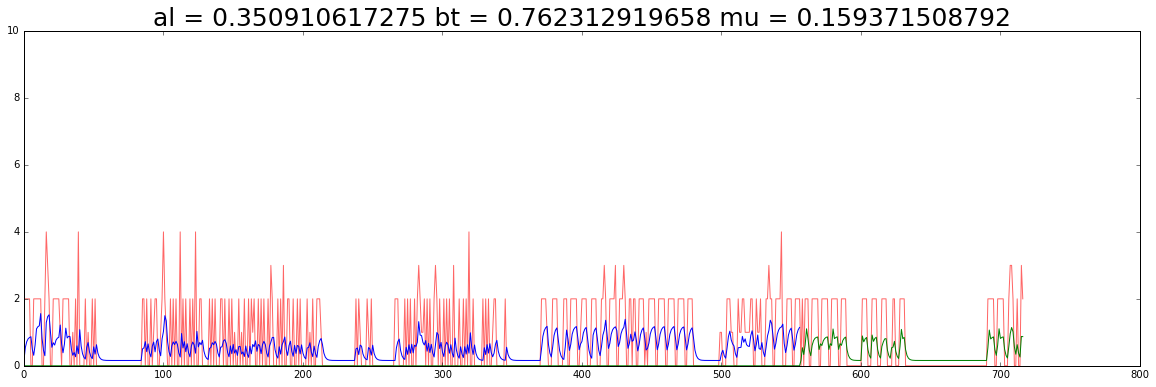

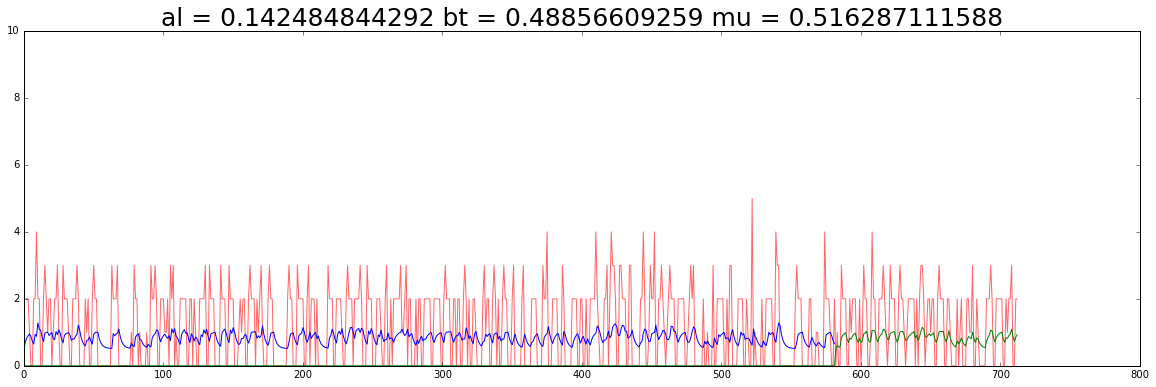

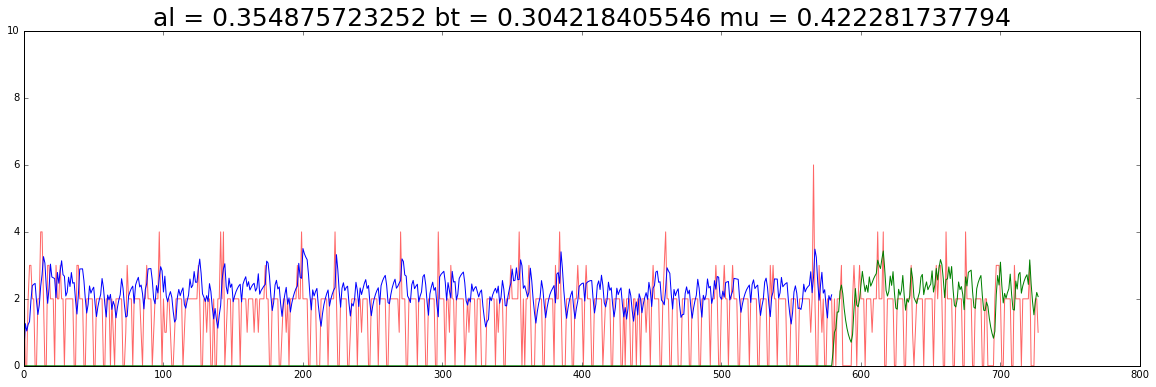

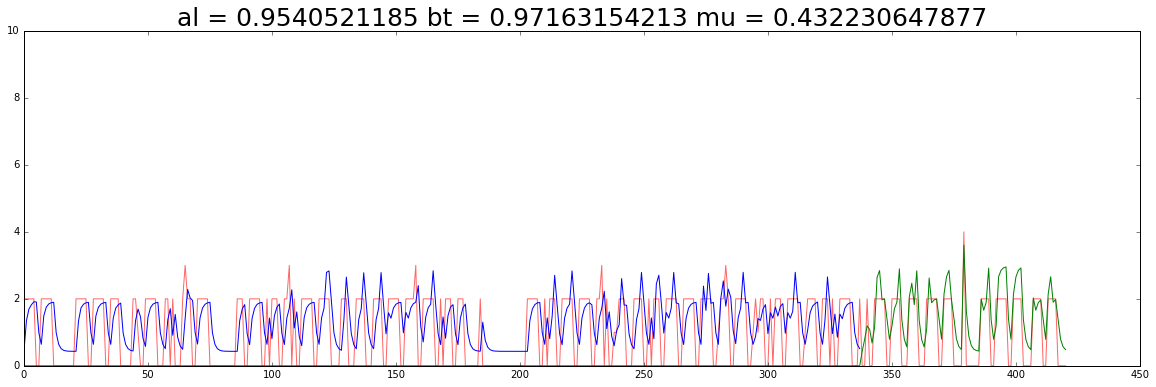

In [212]:
dtw=plot_users(user_params)

In [206]:
for key in dtw.keys():
    print(len(dtw[key]['intensity']),len(dtw[key]['counts']))

726 726
710 710
723 723
611 611
728 728
713 713
717 717
713 713
424 424
421 421


In [202]:
for i in range(len(cnts_train)):
    if not isinstance(cnts_train[i],np.float64):
        print(i,cnts_train[i],len(cnts_train[i]))

TypeError: object of type 'int' has no len()

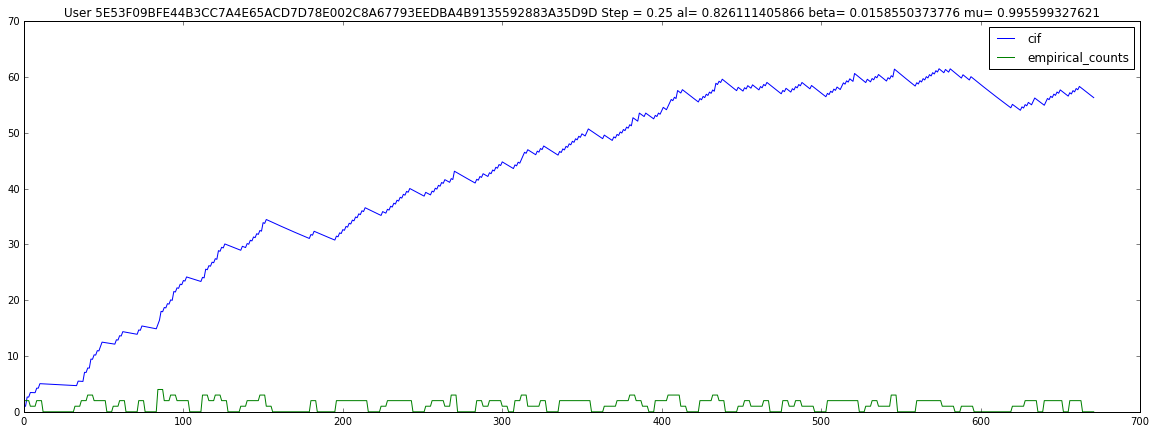

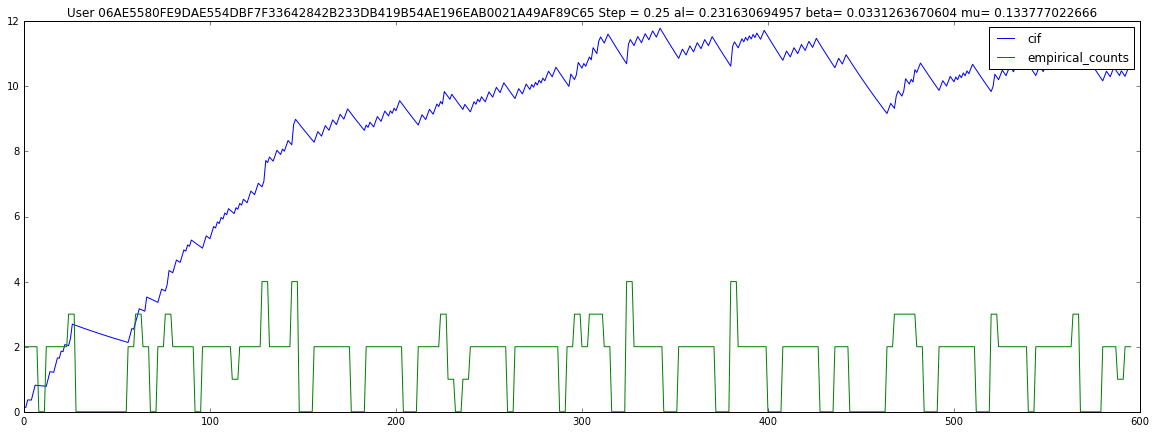

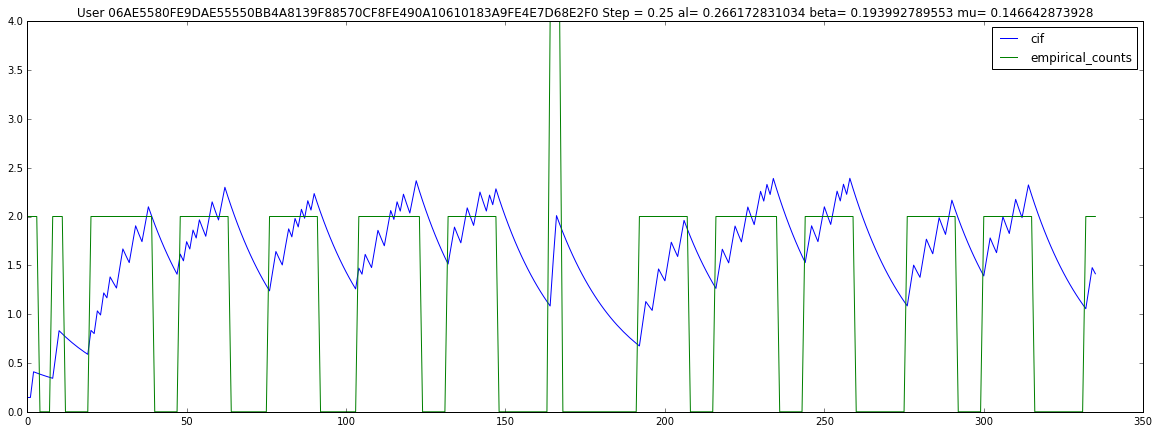

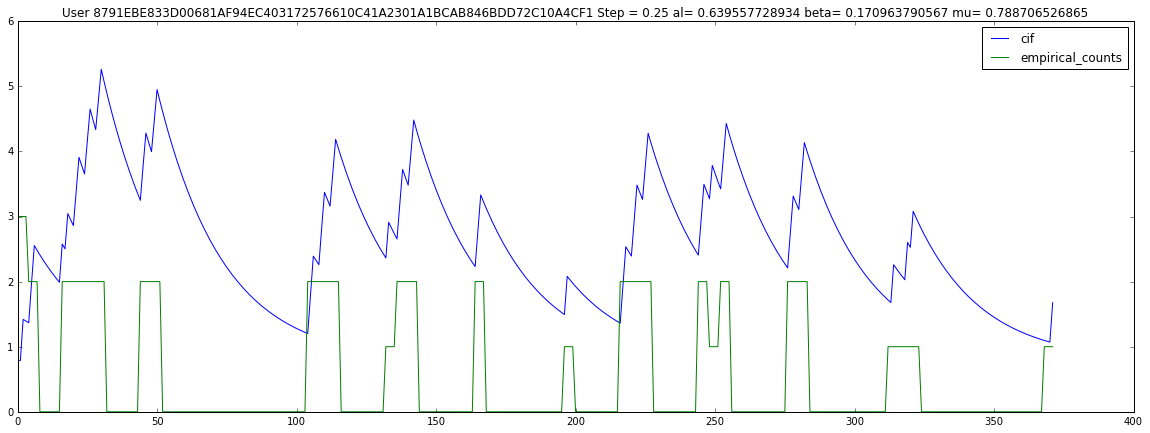

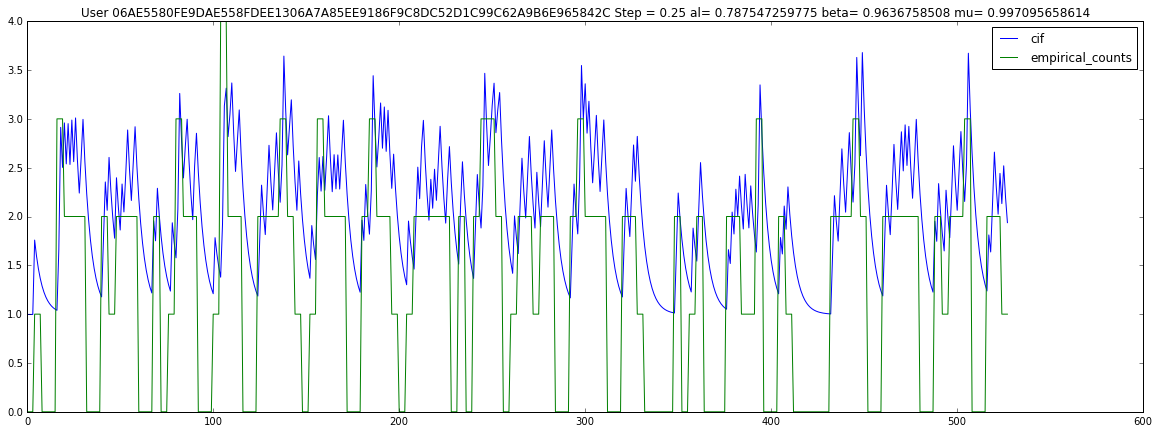

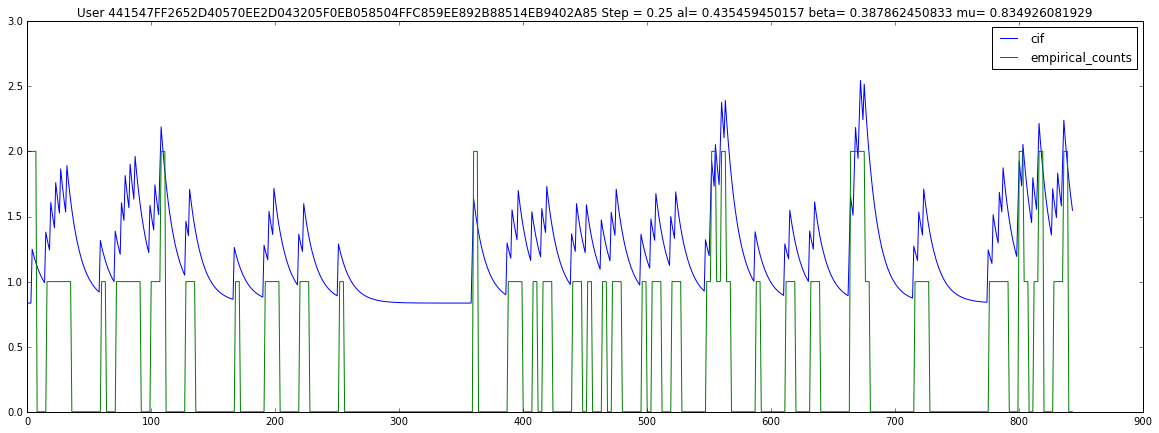

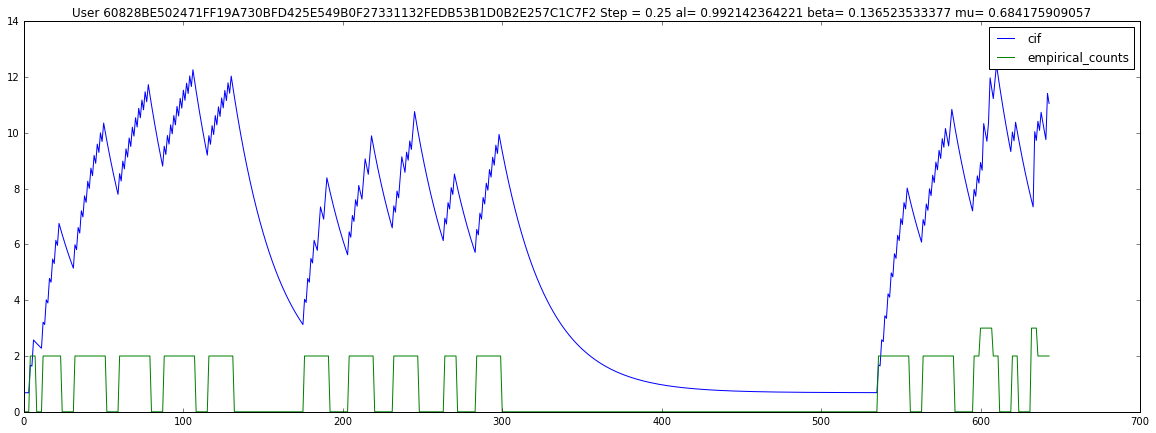

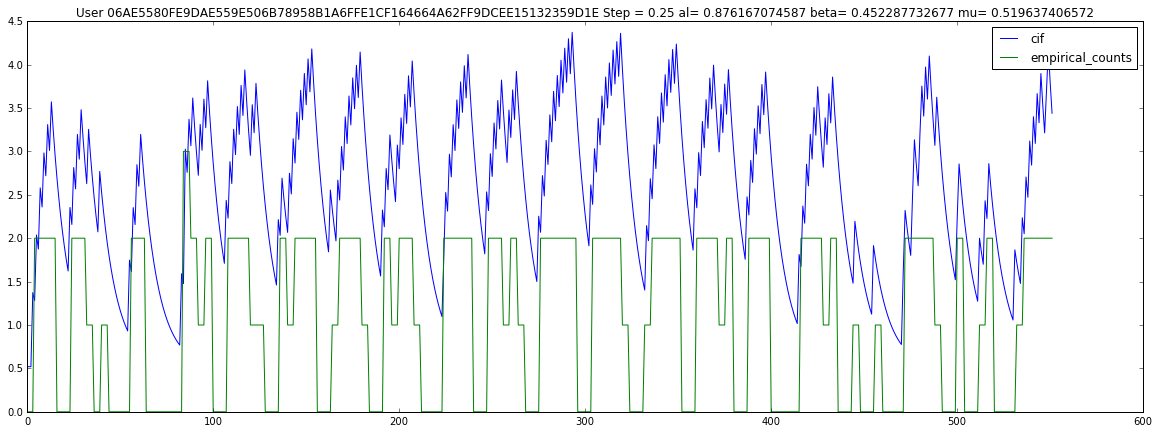

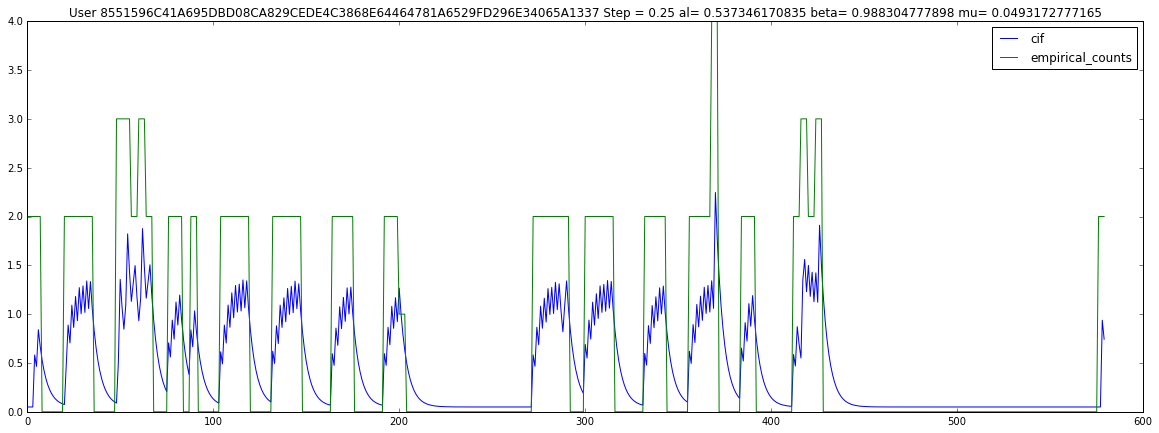

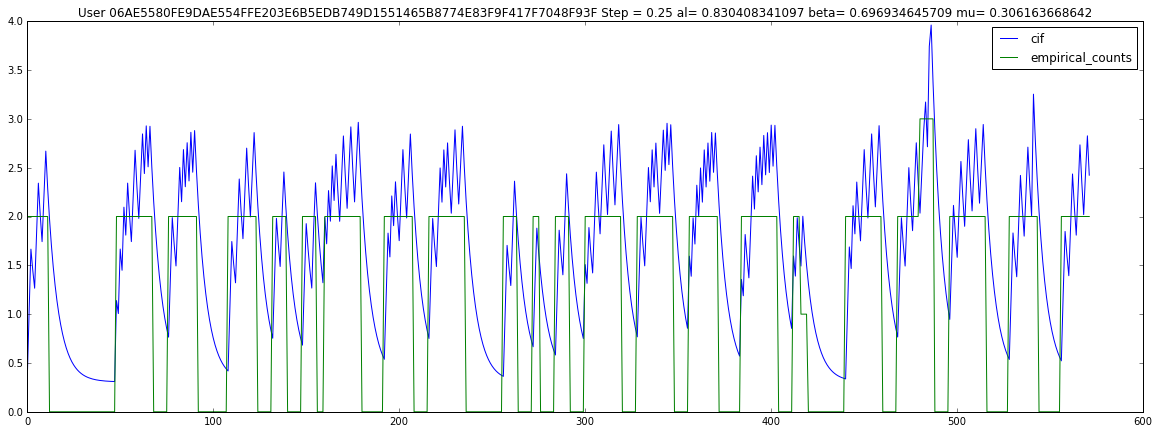

In [66]:
plot_users(step=0.25)

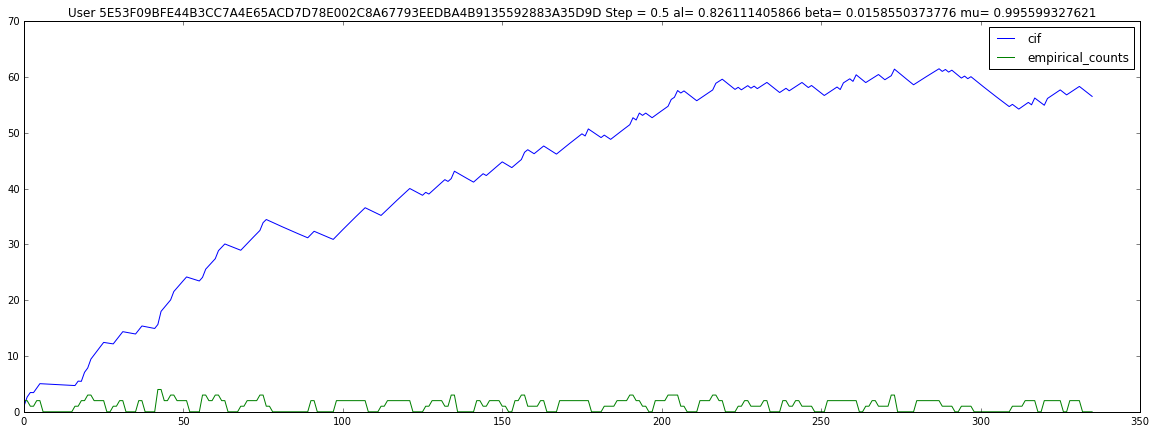

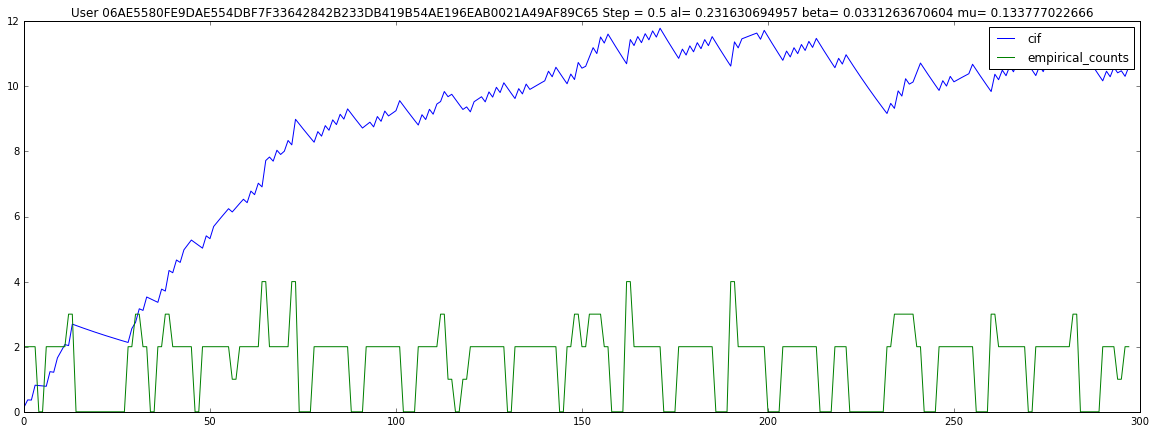

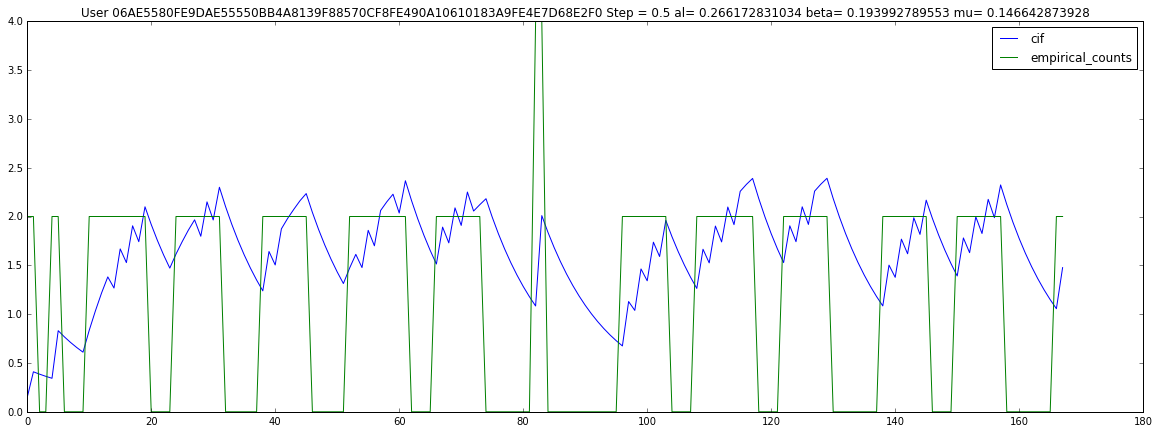

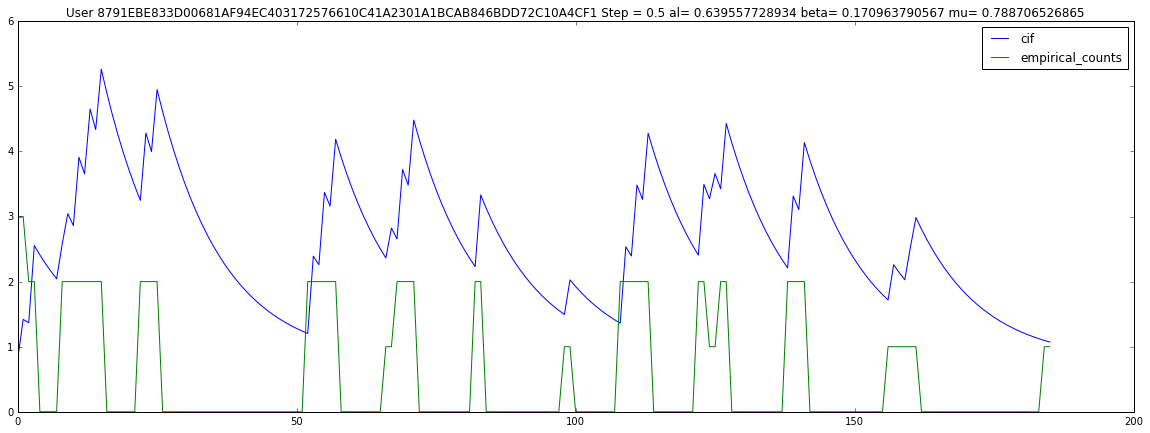

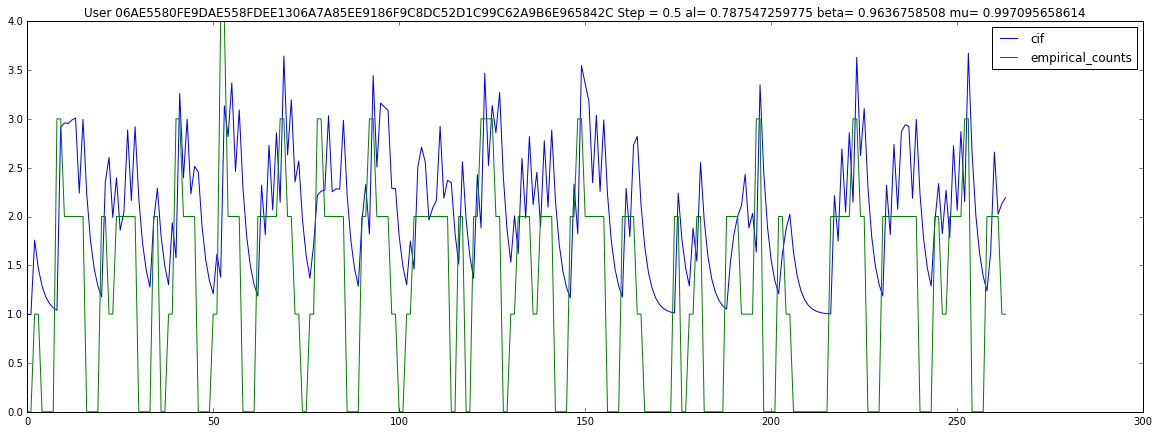

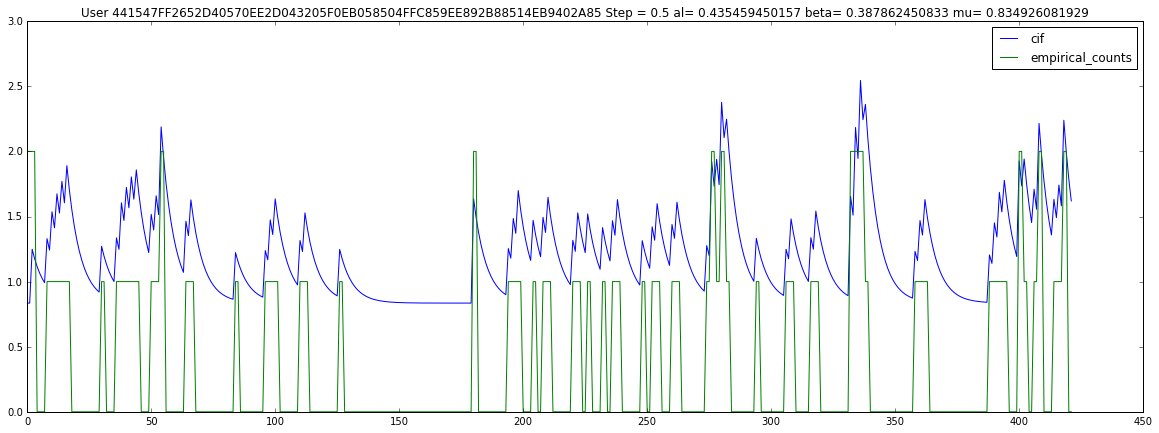

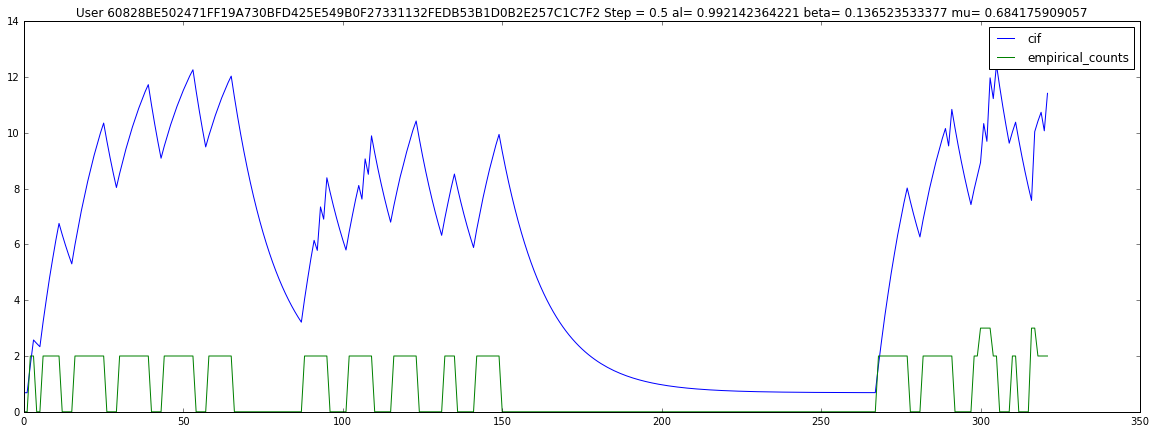

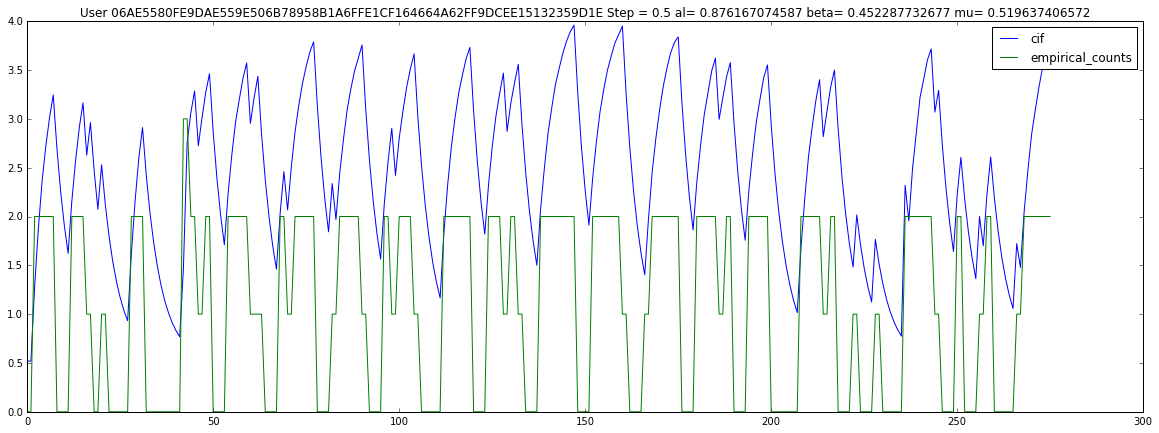

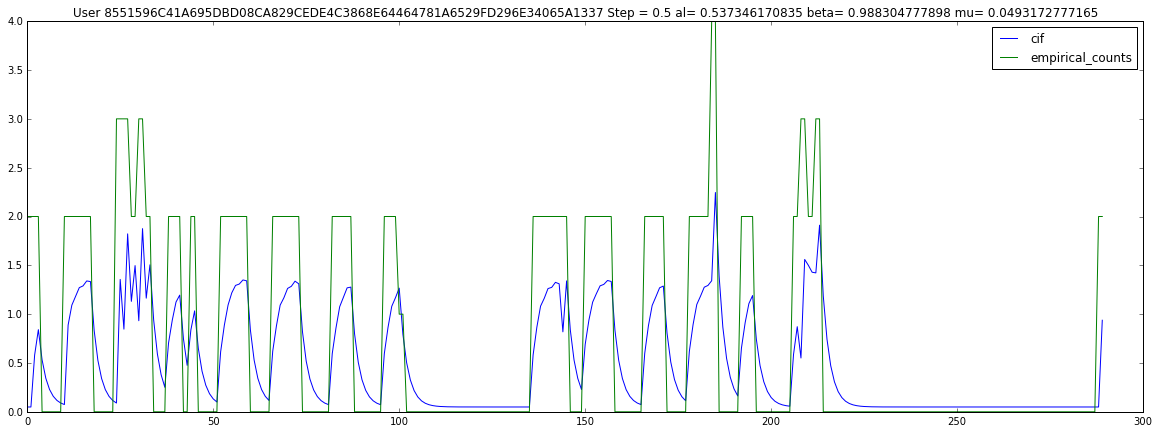

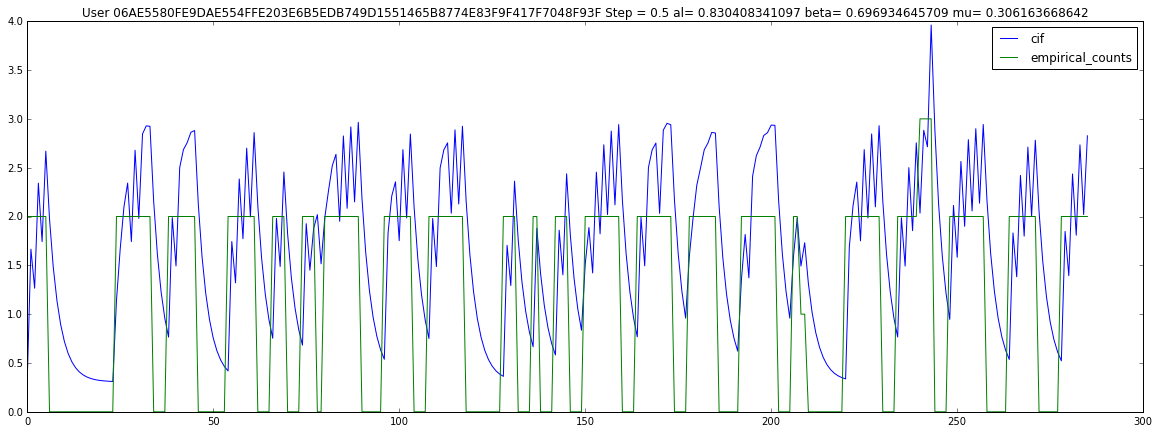

In [67]:
plot_users(step=0.5)

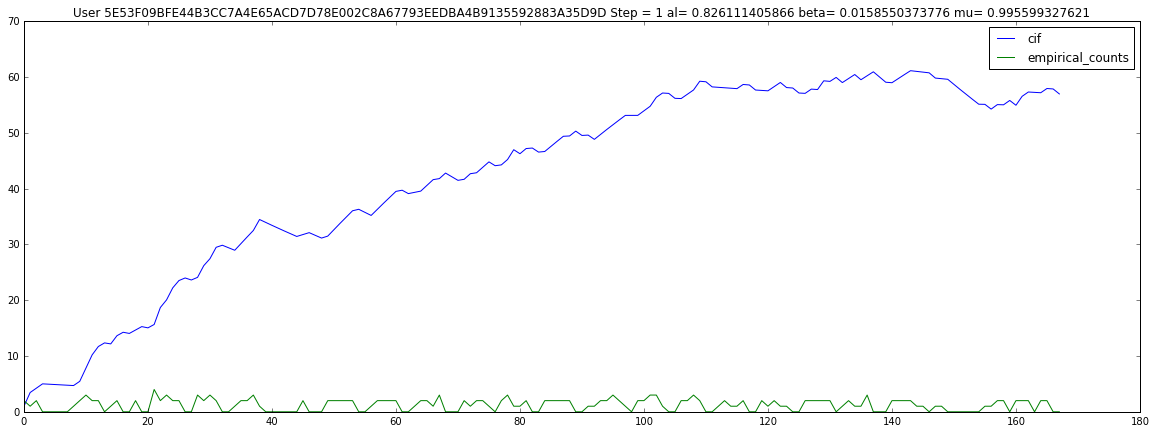

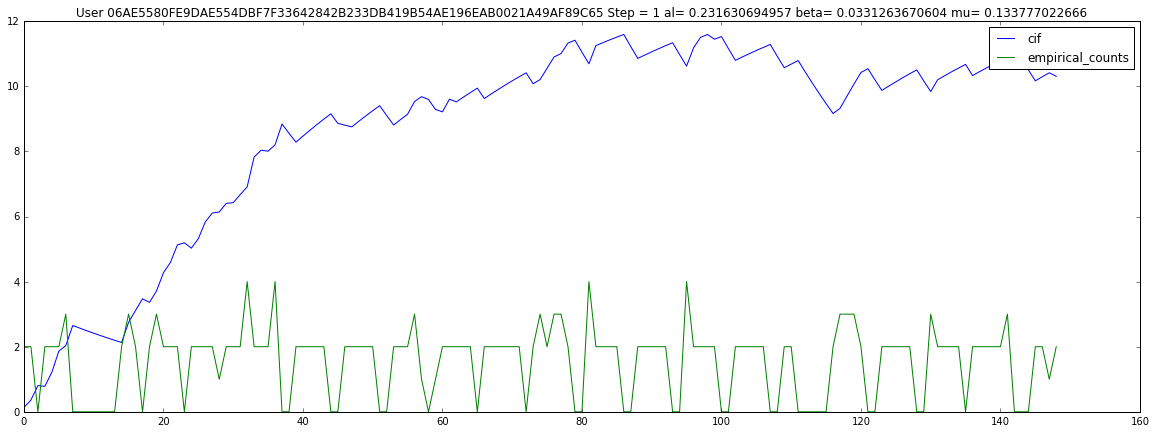

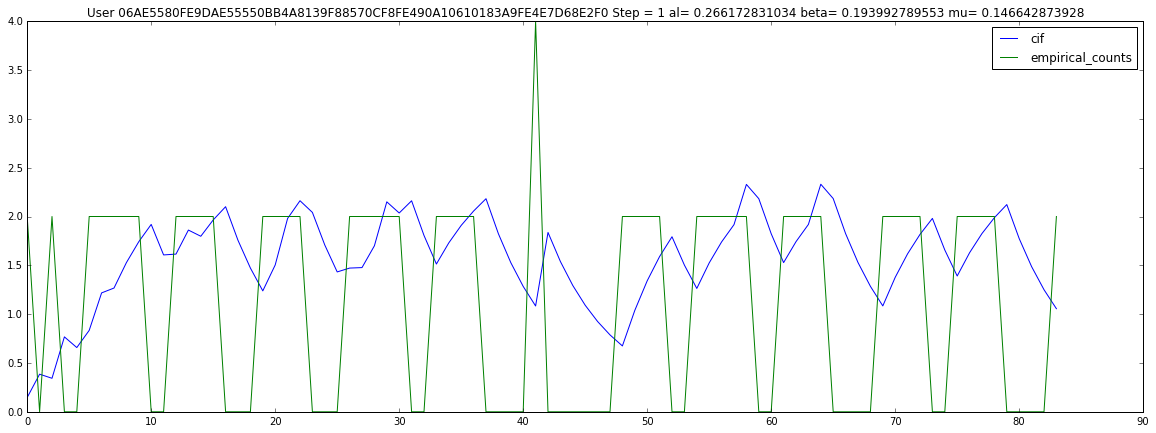

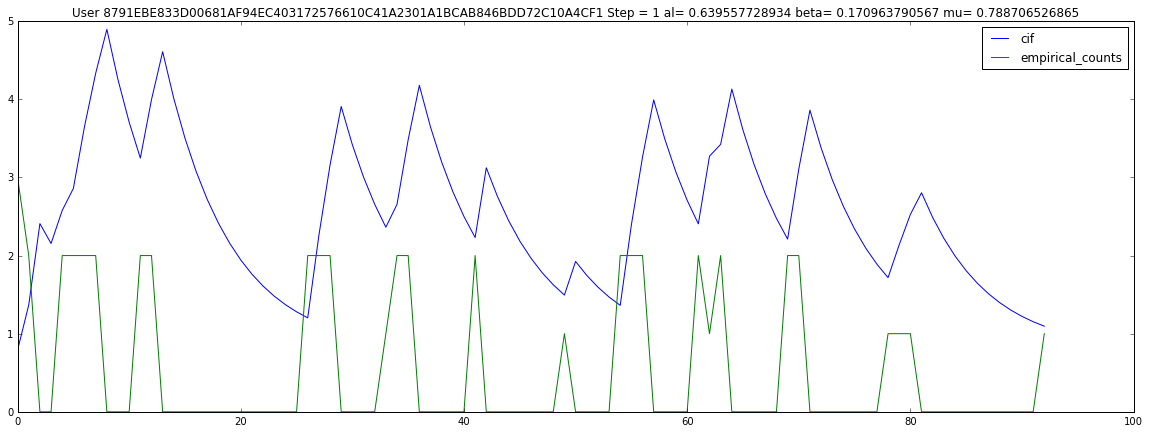

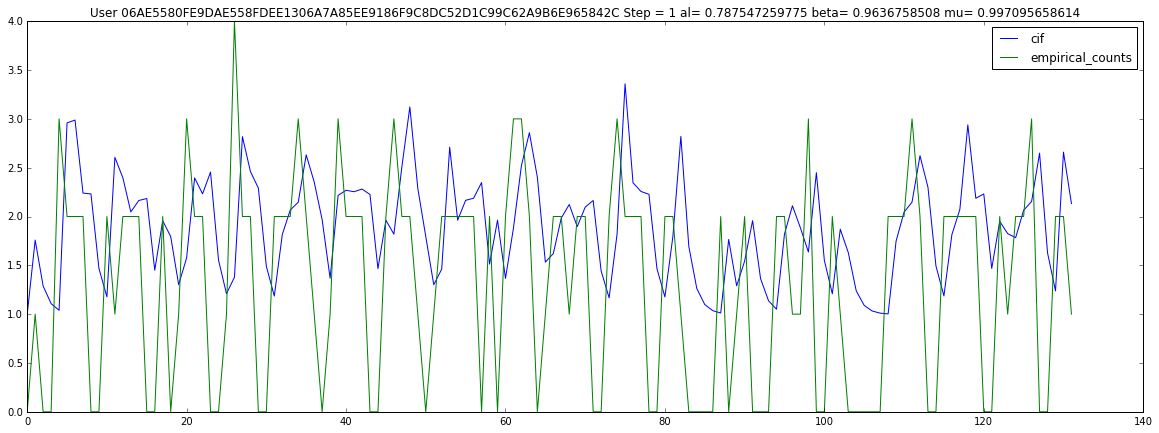

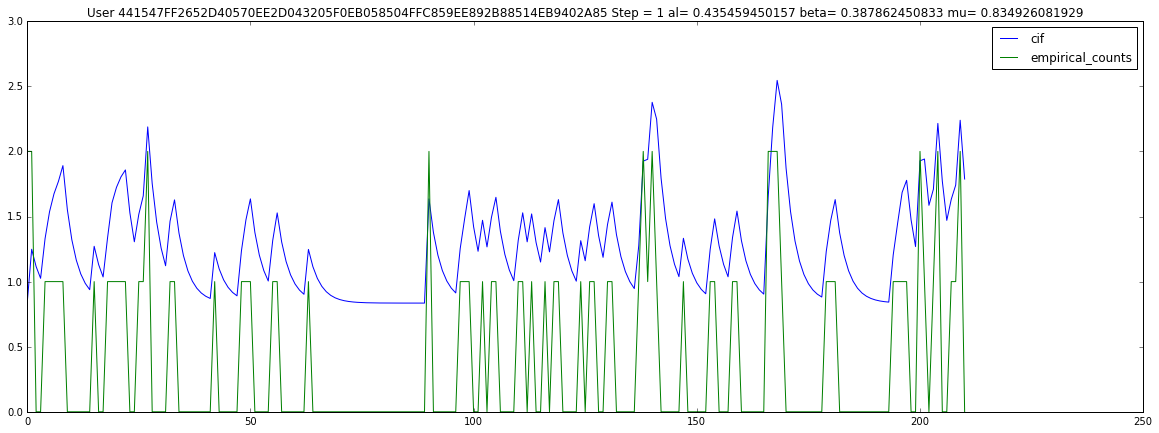

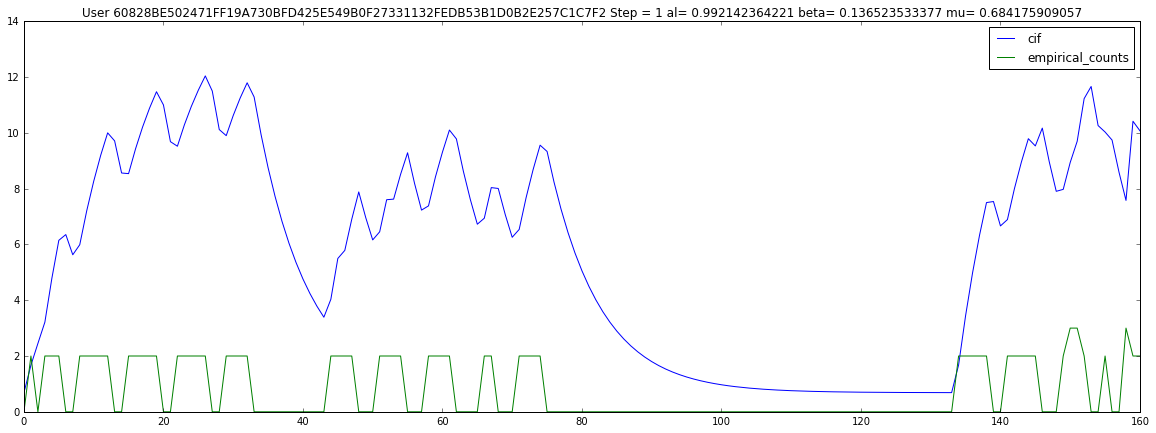

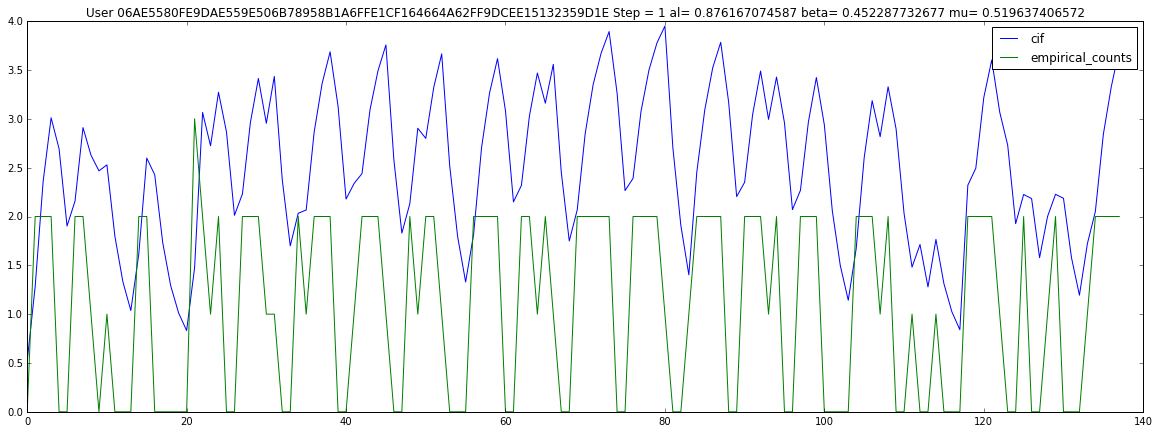

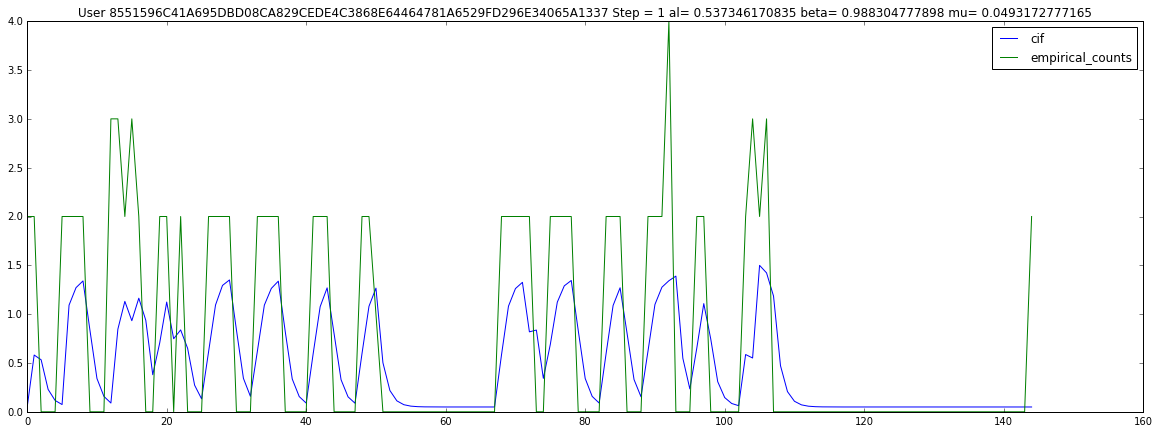

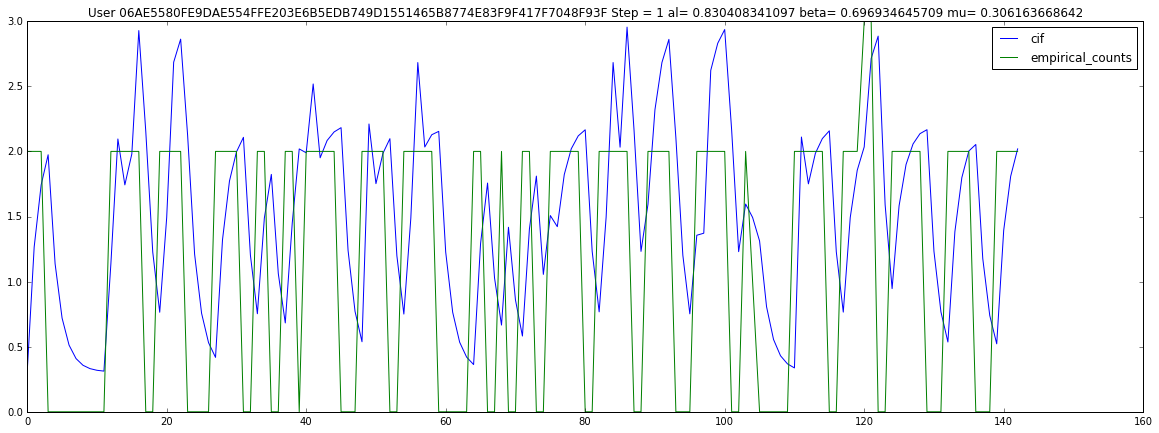

In [49]:
plot_users(step=1)